# Notebook 2/4: Data cleaning (daily traffic and hourly profiles)
***

# Table of contents
1. [Purpose of this notebook](#1)
2. [Daily traffic](#2)
    1. [Description & steps](#2A)
    2. [Cleaning](#2B)
        1. [Rename columns](#2Ba)
        2. [Type conversion](#2Bb)
        3. [Join dataframes](#2Bc)
        4. [Prepare to filter](#2Bd)
        5. [Filter Paris metro stations](#2Be)
        6. [Missing values](#2Bf)
        7. [Drop columns](#2Bg)
    3. [Export to csv](#2C)
3. [Hourly profiles](#3)
    1. [Description & steps](#3A)
    2. [Cleaning](#3B)
        1. [Rename columns](#3Ba)
        2. [Type conversion](#3Bb)
        3. [Filter](#3Bc)
        4. [Join](#3Bd)
        5. [Compute mean hourly profile of 1st & 1nd semesters](#3Be)
        6. [Check data completeness](#3Bf)
        7. [Filter columns](#3Bg)
    3. [Export to csv](#3C)

# 1. Purpose of this notebook: <a name="1"></a>

The purpose of this notebook is to clean the data (following the steps identified in the previous notebook (1/4)) and prepare it for analysis (see notebook 4/4).

For better readability, the cleaning of the stops' repository and geographical coordinates can be found in a separate notebook (see notebook 3/4).

For more information on this data, please refer to notebook 1/4.

# 2. Cleaning: Daily traffic <a name="2"></a>

## 2.A. Description & steps <a name="2A"></a>



nb_2018s1 and nb_2018s2 provide the number of checkins per day, per station (LDA) and per rate plan, for the 1st and 2nd semesters of 2018 respectively.

As a reminder, here are the steps we idenfied:

> Rename columns (translate to english, except columns that contain IDs)

> Handle misdesignated missing values ('ND', '?')

> Cast the CODE_STIF_RES, CODE_STIF_ARRET and NB_VALD columns of nb_2018s1 to numeric

> Cast the ID_REFA_LDA column of nb_2018s2 to numeric

> Convert the JOUR column to datetime in both nb_2018s1 and nb_2018s2

> Concatenate nb_2018s1 & nb_2018s2 into a new dataframe

> Filter Paris metro stations

> Handle remaining missing values

> Export to csv

In [156]:
# Import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [157]:
# Read files with the number of checkins per day

nb_2018s1 = pd.read_csv("../../datasets/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem.csv", sep=";")

nb_2018s2 = pd.read_csv("../../datasets/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem.csv", sep = ";")

# Read repository file.
ref_stops = pd.read_csv('../../datasets/referentiel-arret-tc-idf.csv', sep=';')


## 2.B. Cleaning <a name="2B"></a>

### 2.B.a. Rename columns <a name="2Ba"></a>

In [158]:
# Make sure that column names are the same

nb_2018s1.columns == nb_2018s2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [159]:
# Rename columns (translate to english)

cols = {'JOUR':'DAY', 'LIBELLE_ARRET':'STOP_NAME', 'CATEGORIE_TITRE':'TICKET_TYPE', 'NB_VALD':'NB_CHECKINS'}

nb_2018s1.rename(cols, axis=1, inplace=True)
nb_2018s2.rename(cols, axis=1, inplace=True)

In [160]:
nb_2018s1.columns

Index(['DAY', 'CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET',
       'STOP_NAME', 'ID_REFA_LDA', 'TICKET_TYPE', 'NB_CHECKINS'],
      dtype='object')

In [161]:
nb_2018s2.columns

Index(['DAY', 'CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET',
       'STOP_NAME', 'ID_REFA_LDA', 'TICKET_TYPE', 'NB_CHECKINS'],
      dtype='object')

### 2.B.b. Type conversion <a name="2Bb"></a>

#### Cast the CODE_STIF_RES, CODE_STIF_ARRET and NB_VALD columns of nb_2018s1 to numeric & convert the JOUR column to datetime

In [162]:
# Identify non numeric values in the following columns: 'CODE_STIF_RES', 'CODE_STIF_ARRET', 'NB_CHECKINS'

nb_2018s1.loc[~nb_2018s1['CODE_STIF_RES'].astype(str).str.isnumeric(),'CODE_STIF_RES'].unique()

array(['ND'], dtype=object)

In [163]:
nb_2018s1.loc[~nb_2018s1['CODE_STIF_ARRET'].astype(str).str.isnumeric(),'CODE_STIF_ARRET'].unique()

array(['ND'], dtype=object)

In [164]:
nb_2018s1.loc[~nb_2018s1['NB_CHECKINS'].astype(str).str.isnumeric(),'NB_CHECKINS'].unique()

array(['Moins de 5'], dtype=object)

For the CODE_STIF_RES & CODE_STIF_ARRET columns, the non-numeric values are 'ND' which standes for unavailable (or "Non Disponible" in French). They can be replaced by np.nan while casting the column to numeric by using the errors = 'coerce' keyword argument in the pd.to_numeric() function.

The non-numeric values in the NB_CHECKINS columns are not missing values but indicate values under 5. Let's replace these by the numeric value 4.

In [165]:
# Casting CODE_STIF_RES & CODE_STIF_ARRET and replacing non-numeric values by np.nan

nb_2018s1['CODE_STIF_RES'] = pd.to_numeric(nb_2018s1['CODE_STIF_RES'], errors = 'coerce')
nb_2018s1['CODE_STIF_ARRET'] = pd.to_numeric(nb_2018s1['CODE_STIF_ARRET'], errors = 'coerce')

In [166]:
# Replace non-numeric values in NB_CHECKINS by 4 and cast to numeric:

nb_2018s1['NB_CHECKINS'] = nb_2018s1['NB_CHECKINS'].replace('Moins de 5', '4')
nb_2018s1['NB_CHECKINS'] = pd.to_numeric(nb_2018s1['NB_CHECKINS'])

In [167]:
# Change the DAY column to datetime

nb_2018s1["DAY"] = pd.to_datetime(nb_2018s1["DAY"])

In [168]:
# Check nb_2018s1 data types

nb_2018s1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777436 entries, 0 to 777435
Data columns (total 8 columns):
DAY                777436 non-null datetime64[ns]
CODE_STIF_TRNS     777436 non-null int64
CODE_STIF_RES      776001 non-null float64
CODE_STIF_ARRET    776001 non-null float64
STOP_NAME          777436 non-null object
ID_REFA_LDA        767645 non-null float64
TICKET_TYPE        777436 non-null object
NB_CHECKINS        777436 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 47.5+ MB


#### Cast the ID_REFA_LDA column of nb_2018s2 to numeric & convert the JOUR column to datetime

In [169]:
# Identify non numeric values in ID_REFA_LDA

nb_2018s2.loc[~nb_2018s2['ID_REFA_LDA'].astype(str).str.isnumeric(),'ID_REFA_LDA'].unique()

array(['?', nan], dtype=object)

In [170]:
# Cast the ID_REFA_LDA column of nb_2018s2 to numeric

nb_2018s2['ID_REFA_LDA'] = pd.to_numeric(nb_2018s2['ID_REFA_LDA'], errors = 'coerce')

In [171]:
# Change the DAY column to datetime

nb_2018s2["DAY"] = pd.to_datetime(nb_2018s2["DAY"])

In [172]:
nb_2018s2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883145 entries, 0 to 883144
Data columns (total 8 columns):
DAY                883145 non-null datetime64[ns]
CODE_STIF_TRNS     883145 non-null int64
CODE_STIF_RES      881677 non-null float64
CODE_STIF_ARRET    881677 non-null float64
STOP_NAME          883145 non-null object
ID_REFA_LDA        871326 non-null float64
TICKET_TYPE        883145 non-null object
NB_CHECKINS        765356 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


### 2.B.c. Join dataframes <a name="2Bc"></a>

In [173]:
# Make sure that no day appears twice in the s1 and s2 dataframes by merging them with an inner join on the DAY column

compare = pd.merge(left = nb_2018s1, right = nb_2018s2, how = 'inner', on = 'DAY')

compare.shape

(0, 15)

The resulting dataframe has 0 lines, meaning that there are no common values in the DAY columns of the s1 and s2 dataframes.

In [174]:
# Concatenate s1 and s2 into a new dataframe

nb_checkins = pd.concat([nb_2018s1, nb_2018s2], axis=0)

In [175]:
nb_checkins.head()

,DAY,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,STOP_NAME,ID_REFA_LDA,TICKET_TYPE,NB_CHECKINS
0,2018-05-09,100,110.0,1006.0,OLYMPIADES,71557.0,AMETHYSTE,462.0
1,2018-05-09,100,110.0,1006.0,OLYMPIADES,71557.0,NAVIGO,10764.0
2,2018-05-09,100,110.0,1007.0,LES AGNETTES-ASNIERES-GENNEVILLIERS,72240.0,NAVIGO,3972.0
3,2018-05-09,100,110.0,1008.0,LES COURTILLES,72286.0,TST,813.0
4,2018-05-09,100,110.0,104.0,BOURSE,73635.0,?,4.0


### 2.B.d. Prepare to filter <a name="2Bd"></a>

In [176]:
nb_checkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1660581 entries, 0 to 883144
Data columns (total 8 columns):
DAY                1660581 non-null datetime64[ns]
CODE_STIF_TRNS     1660581 non-null int64
CODE_STIF_RES      1657678 non-null float64
CODE_STIF_ARRET    1657678 non-null float64
STOP_NAME          1660581 non-null object
ID_REFA_LDA        1638971 non-null float64
TICKET_TYPE        1660581 non-null object
NB_CHECKINS        1542792 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 114.0+ MB


We see that the following columns have missing values:
- CODE_STIF_RES
- CODE_STIF_ARRET
- ID_REFA_LDA 
- NB_CHECKINS

In [177]:
nb_checkins.nunique()

DAY                  365
CODE_STIF_TRNS         3
CODE_STIF_RES         13
CODE_STIF_ARRET      753
STOP_NAME            732
ID_REFA_LDA          721
TICKET_TYPE            8
NB_CHECKINS        22771
dtype: int64

There also might be columns where missing values are indicated by strings and therefore are not easily identifiable.

Some of the missing values will probably be dropped as we will filter nb_checkins on the CODE_STIF_RES column.

Before handling missing values on all these columns, let's look at the missing CODE_STIF_RES. Then we can filter our data and look at the remaining missing values.

In [178]:
nb_checkins['CODE_STIF_RES'].unique()

array([110., 804., 805., 853., 852.,  nan, 800., 803., 854., 802., 801.,
       850., 822., 851.])

In [179]:
nb_checkins['CODE_STIF_RES'].isnull().sum()

2903

In [180]:
nb_checkins.loc[nb_checkins['CODE_STIF_RES'].isnull(), 'STOP_NAME'].unique()

array(['Inconnu'], dtype=object)

We see that the only rows that have a missing CODE_STIF_RES are those with an 'Inconnu' (='Unknown') STOP_NAME.

Let's make sure that 'Inconnu' is not a valid metro station.

In [181]:
# Standardize capitalisation in the STOP_NAME column

nb_checkins['STOP_NAME'] = nb_checkins['STOP_NAME'].str.upper()

In [182]:
stop_unknown = nb_checkins.loc[nb_checkins['STOP_NAME'] == 'INCONNU']

In [183]:
stop_unknown[['DAY', 'TICKET_TYPE']].describe()

,DAY,TICKET_TYPE
count,2903,2903
unique,365,8
top,2018-03-03 00:00:00,AMETHYSTE
freq,8,365
first,2018-01-01 00:00:00,NaN
last,2018-12-31 00:00:00,NaN


We can see that the data is evenly distributed among all 365 days of the year and all 7 rate plans.

In [184]:
# Check in the stops repository dataset if INCONNU appears

ref_stops['LDA_NOM'] = ref_stops['LDA_NOM'].str.upper()

In [185]:
def check_name(x):
    if (ref_stops['LDA_NOM'] == x).sum() == 0:
        x_list = x.split()
        matches = []
        if len(x_list) > 1:
            m_lst = ref_stops.loc[ref_stops['LDA_NOM'].str.contains(x_list[0]), 'LDA_NOM'].unique()
            matches.append(m_lst)
        else:
            matches = ref_stops.loc[ref_stops['LDA_NOM'].str.contains(x_list[0]), 'LDA_NOM'].unique()
    else:
        matches = ref_stops.loc[ref_stops['LDA_NOM'] == x, 'LDA_NOM'].unique()
    return matches

In [186]:
check_name('INCONNU')

array([], dtype=object)

'INCONNU' is not a valid STOP_NAME and indicates a missing value. These rows will be dropped as we filter on CODE_STIF_RES.

### 2.B.e. Filter Paris metro stations <a name="2Be"></a>

To filter Paris metro stations only, we can use the CODE_STIF_RES 110.

In [187]:
nb_checkins['CODE_STIF_RES'].value_counts()

110.0    744502
803.0    140856
854.0    132786
801.0    112889
802.0    107446
804.0     99488
853.0     91762
852.0     66395
850.0     54753
805.0     46934
851.0     32367
800.0     14302
822.0     13198
Name: CODE_STIF_RES, dtype: int64

In [188]:
# Let's look at values for 1 random day for GARE DE LYON, which we know has multiple stop types (metro, train, etc.)

nb_checkins.loc[(nb_checkins['DAY'] == '2018-01-01')&(nb_checkins['STOP_NAME'].str.contains('GARE DE LYON'))]

,DAY,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,STOP_NAME,ID_REFA_LDA,TICKET_TYPE,NB_CHECKINS
161,2018-01-01,800,804.0,307.0,GARE DE LYON,73626.0,IMAGINE R,332.0
162,2018-01-01,800,804.0,307.0,GARE DE LYON,73626.0,AMETHYSTE,37.0
1342,2018-01-01,810,801.0,306.0,GARE DE LYON,73626.0,TST,800.0
27994,2018-01-01,100,110.0,317.0,GARE DE LYON,73626.0,FGT,203.0
27995,2018-01-01,100,110.0,317.0,GARE DE LYON,73626.0,TST,172.0
29920,2018-01-01,810,801.0,306.0,GARE DE LYON,73626.0,AMETHYSTE,366.0
29921,2018-01-01,810,801.0,306.0,GARE DE LYON,73626.0,NAVIGO,17061.0
29923,2018-01-01,810,801.0,306.0,GARE DE LYON,73626.0,?,5.0
30771,2018-01-01,100,110.0,317.0,GARE DE LYON,73626.0,IMAGINE R,918.0
30772,2018-01-01,100,110.0,317.0,GARE DE LYON,73626.0,AMETHYSTE,181.0


Looking at the dataframe above, we see that for 1 LDA, there are multiple CODE_STIF_ARRET. The CODE_STIF_ARRET is different for each network category within a station. The different network categories are designated by the CODE_STIF_RES, which uses the number 110 for metro network.

In [189]:
# Filter by metro station

metro_nb = nb_checkins.loc[nb_checkins['CODE_STIF_RES']==110]

In [190]:
# Shape of the filtered dataframe

metro_nb.shape

(744502, 8)

In [191]:
metro_nb['STOP_NAME'].nunique()

301

This number is consistent with the number indicated in the Wikipedia page for Paris metro: 302 (https://en.wikipedia.org/wiki/Paris_M%C3%A9tro)

A station might be missing from metro_nb. We will have to check it with the repository of metro stations and the geographical data of metro stations.

In [192]:
metro_nb['NB_CHECKINS'].sum()

971230981.0

### 2.B.f. Missing values <a name="2Bf"></a>

In [193]:
metro_nb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744502 entries, 0 to 883141
Data columns (total 8 columns):
DAY                744502 non-null datetime64[ns]
CODE_STIF_TRNS     744502 non-null int64
CODE_STIF_RES      744502 non-null float64
CODE_STIF_ARRET    744502 non-null float64
STOP_NAME          744502 non-null object
ID_REFA_LDA        742269 non-null float64
TICKET_TYPE        744502 non-null object
NB_CHECKINS        710580 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 51.1+ MB


In [194]:
metro_nb.nunique()

DAY                  365
CODE_STIF_TRNS         1
CODE_STIF_RES          1
CODE_STIF_ARRET      301
STOP_NAME            301
ID_REFA_LDA          300
TICKET_TYPE            8
NB_CHECKINS        19339
dtype: int64

We see that the TICKET_TYPE column has 8 unique values instead of 7. We saw before that some missing values were designated by a question mark in the column.

There are missing ID_REFA_LDA. This column has 300 unique values when it should have 301 (as CODE_STIF_ARRET and STOP_NAME). 1 ID_REFA_LDA is probably missing for a bunch of rows.

Finally, NB_CHECKINS has missing values. 

#### TICKET_TYPE

In [195]:
metro_nb['TICKET_TYPE'].value_counts()

AUTRE TITRE    107995
NAVIGO         107959
IMAGINE R      107906
FGT            107893
TST            107886
AMETHYSTE      107882
?               88752
NON DEFINI       8229
Name: TICKET_TYPE, dtype: int64

We see that there are 2 incorrectly designated missing values in the TICKET_TYPE column: '?' and 'NON DEFINI' (undefined). These indicate anomalies at the time of checkin.

'AUTRE TITRE' (other type of fare) could suggest that the rate plan is unknown, but it does in fact designate a group of other special rate plans that probably are not common enough each on its own to appear in separate groups.

Fortunately, '?' and 'NON DEFINI' are not as frequent as the 6 valid plan rates.

The fact that each rate plan does not have the same number of rows means that when no checkins are registered for a specific day, stop and rate plan, the row is missing from the data.

Let's see if dropping the lines for which the TICKET_TYPE column is '?' or 'NON DEFINI' would cause information loss.

In [196]:
# Rows where the TICKET_TYPE is missing

rate_missing = metro_nb[metro_nb['TICKET_TYPE'].isin(['?','NON DEFINI'])]

In [197]:
rate_missing[['DAY','STOP_NAME']].describe()

,DAY,STOP_NAME
count,96981,96981
unique,365,301
top,2018-10-13 00:00:00,PALAIS ROYAL-MUSEE DU LOUVRE
freq,398,459
first,2018-01-01 00:00:00,NaN
last,2018-12-31 00:00:00,NaN


Missing values are distributed among all the values in the DAY column and most of the values in the STOP_NAME column.

In [198]:
rate_missing_perc = (rate_missing['NB_CHECKINS'].sum()/metro_nb['NB_CHECKINS'].sum())*100
rate_missing_perc

0.05104511796869874

Missing rate values account for more than 0.05% of all checkins.

Let's make sure that the number of checkins when the rate plan is missing is proportionate to the total number of checkins for stops.

#### Correlation between missing ticket type and number of checkins per stop

In [199]:
# Group metro_nb by 'STOP_NAME' and sum() 'NB_CHECKINS'. Sort in ascending order by 'NB_CHECKINS'

gp_stop = metro_nb.groupby('STOP_NAME')
sum_stop = gp_stop.sum().sort_values('NB_CHECKINS', ascending=True)
sum_stop = sum_stop.reset_index()
sum_stop = sum_stop[['STOP_NAME', 'NB_CHECKINS']]

# Group rate_missing by 'STOP_NAME' and sum() 'NB_CHECKINS'

gp_stop_missing = rate_missing.groupby('STOP_NAME')
sum_stop_missing = gp_stop_missing.sum()
sum_stop_missing.reset_index(inplace=True)
sum_stop_missing = sum_stop_missing[['STOP_NAME', 'NB_CHECKINS']]

# Merge both dataframes. The resulting dataframe is sorted by 'NB_CHECKINS'

join_stop = pd.merge(left=sum_stop, right=sum_stop_missing, on='STOP_NAME', how='left', suffixes=('_all','_missing_rate'))


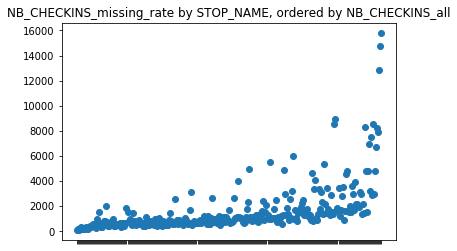

In [200]:
# Plot the NB_CHECKINS_all and NB_CHECKINS_missing_rate columns of the join_stop dataframe to see if they are correlated

x = join_stop['STOP_NAME']
y = join_stop['NB_CHECKINS_missing_rate']

fig, ax = plt.subplots()

ax.set_xticklabels([])

ax.set_title("NB_CHECKINS_missing_rate by STOP_NAME, ordered by NB_CHECKINS_all")

ax.scatter(x,y)

plt.show()

In [201]:
# Pearson correlation coefficient

join_stop_corr = join_stop[['NB_CHECKINS_all', 'NB_CHECKINS_missing_rate']].corr()
join_stop_corr

,NB_CHECKINS_all,NB_CHECKINS_missing_rate
NB_CHECKINS_all,1.00000,0.82108
NB_CHECKINS_missing_rate,0.82108,1.00000


There is a high correlation between the number of checkins with missing information about the rate plan and the total number of checkins per stop. For NB_CHECKINS above 10 million, the correlation still holds but the slope is much steeper.

Therefore, dropping those rows would not result in a loss of information when it comes to the number of checkins per stop.

#### Correlation between missing ticket type and number of checkins per day

In [202]:
# Group metro_nb by 'DAY' and sum() 'NB_CHECKINS'. Sort in ascending order by 'NB_CHECKINS'

gp_day = metro_nb.groupby('DAY')
sum_day = gp_day.sum().sort_values('NB_CHECKINS', ascending=True)
sum_day.reset_index(inplace=True)
sum_day = sum_day[['DAY', 'NB_CHECKINS']]

# Group rate_missing by 'DAY' and sum() 'NB_CHECKINS'

gp_day_missing = rate_missing.groupby('DAY')
sum_day_missing = gp_day_missing.sum()
sum_day_missing.reset_index(inplace=True)
sum_day_missing = sum_day_missing[['DAY', 'NB_CHECKINS']]

# Merge both dataframes. The resulting dataframe is sorted by 'NB_CHECKINS'

join_day = pd.merge(left=sum_day, right=sum_day_missing, on='DAY', how='left', suffixes=('_all','_missing_rate'))

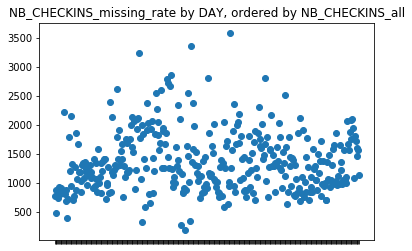

In [203]:
# Plot the NB_CHECKINS_all and NB_CHECKINS_missing_rate columns of the join_day dataframe to see if they are correlated

x = join_day['DAY'].astype('str')
y = join_day['NB_CHECKINS_missing_rate']

fig, ax = plt.subplots()

ax.set_xticklabels([])

ax.set_title('NB_CHECKINS_missing_rate by DAY, ordered by NB_CHECKINS_all')

ax.scatter(x,y)

plt.show()

In [204]:
# Pearson correlation coefficient

join_day_corr = join_day[['NB_CHECKINS_all', 'NB_CHECKINS_missing_rate']].corr()
join_day_corr

,NB_CHECKINS_all,NB_CHECKINS_missing_rate
NB_CHECKINS_all,1.000000,0.066216
NB_CHECKINS_missing_rate,0.066216,1.000000


The correlation between the number of checkins with missing data regarding the rate plan and the total number of checkins per day is weak. This actually makes sense, because when such anomalies occur, they probably impact most of the checkins for the day, regardless of how busy that day is. On the other hand, if a station has a high number of checkins year round, such anomalies will impact a high number of checkins, regardless of the day when the anomaly occurs.

Dropping those rows would not impact our analysis of the number of checkins per stop, but it would impact our analysis per day.

Let's keep these rows but re-label them.

In [205]:
# Replace '?' and 'NON DEFINI' by 'NA' (Not available)

metro_nb['TICKET_TYPE'].replace(['?', 'NON DEFINI'], ['NA', 'NA'],inplace=True)

/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [206]:
metro_nb['TICKET_TYPE'].value_counts()

AUTRE TITRE    107995
NAVIGO         107959
IMAGINE R      107906
FGT            107893
TST            107886
AMETHYSTE      107882
NA              96981
Name: TICKET_TYPE, dtype: int64

#### ID_REFA_LDA

In [207]:
# Identify the missing ID_REFA_LDA

metro_nb.loc[metro_nb['ID_REFA_LDA'].isnull(),'STOP_NAME'].unique()

array(['PORTE DAUPHINE'], dtype=object)

The ID_REFA_LDA is missing for the station PORTE DAUPHINE.

In [208]:
metro_nb[metro_nb['ID_REFA_LDA'].isnull()].head()

,DAY,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,STOP_NAME,ID_REFA_LDA,TICKET_TYPE,NB_CHECKINS
1018,2018-05-09,100,110.0,682.0,PORTE DAUPHINE,NaN,IMAGINE R,2106.0
3704,2018-01-03,100,110.0,682.0,PORTE DAUPHINE,NaN,AUTRE TITRE,98.0
4831,2018-01-07,100,110.0,682.0,PORTE DAUPHINE,NaN,FGT,89.0
4832,2018-01-07,100,110.0,682.0,PORTE DAUPHINE,NaN,NAVIGO,1337.0
4833,2018-01-07,100,110.0,682.0,PORTE DAUPHINE,NaN,TST,147.0


Let's see if we can replace it using ref_stops

In [209]:
pd_lda = ref_stops.loc[ref_stops['LDA_NOM'] == 'PORTE DAUPHINE', 'LDA_ID_REF_A'].unique()[0]

pd_lda = pd_lda.astype(int)

pd_lda

474152

In [210]:
# Replace missing values by 474152

metro_nb.loc[metro_nb['STOP_NAME'] == 'PORTE DAUPHINE', 'ID_REFA_LDA'] = pd_lda

/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### NB_CHECKINS

In [211]:
# Percentage of rows with missing number of checkins

perc_missing = (len(metro_nb[metro_nb['NB_CHECKINS'].isnull()]))/(len(metro_nb))

perc_missing

0.04556334301318197

Missing values in the NB_CHECKINS column account for 4.5% of all rows.

Let's see if these missing values correspond to data from a particular column. 

In [212]:
metro_nb.loc[metro_nb['NB_CHECKINS'].isnull(), ['DAY', 'ID_REFA_LDA', 'TICKET_TYPE']].nunique()

DAY            184
ID_REFA_LDA    301
TICKET_TYPE      7
dtype: int64

These missing values are distributed among all ID_REFA_LDA and all TICKET_TYPE unique values.

However, we see that these anomalies only occured during the 2nd semester of 2018.

Earlier, we saw that data from the 1st semester had strings indicating 'moins de 5' (=less than 5). When there were 0 to and incl. 4 checkins, the STIF did not provide the exact number to prevent the tracking of a particular individual. We replaced these values by 4 in order to cast the column to numeric. 

It is possible that the same logic was applied for the 2nd semester, but that it is indicated by NaNs.

In [213]:
# Percentage of rows with a number of checkins less than 5

perc_less5 = len(metro_nb.loc[metro_nb['NB_CHECKINS'] == 4])/len(metro_nb)

Almost 4% of rows have less than 5 checkins. It seems in line with our hypothesis. 

To confirm it, let's see if there were NB_CHECKINS values that were less than 5 in the dataset for the 2nd semester (nb_2018s2)

In [214]:
len(nb_2018s2[nb_2018s2['NB_CHECKINS']<5])

0

In [215]:
len(nb_2018s2[nb_2018s2['NB_CHECKINS']==5])

14329

In [216]:
len(nb_2018s2[nb_2018s2['NB_CHECKINS']>5])

751027

We see that there were no rows with NB_CHECKINS less than 5 in the data from the 2nd semester. This confirms that the NaNs correspond to values that are less than 5. Let's replace them by 4.

In [217]:
metro_nb['NB_CHECKINS'] = metro_nb['NB_CHECKINS'].fillna(4)

/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [218]:
metro_nb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744502 entries, 0 to 883141
Data columns (total 8 columns):
DAY                744502 non-null datetime64[ns]
CODE_STIF_TRNS     744502 non-null int64
CODE_STIF_RES      744502 non-null float64
CODE_STIF_ARRET    744502 non-null float64
STOP_NAME          744502 non-null object
ID_REFA_LDA        744502 non-null float64
TICKET_TYPE        744502 non-null object
NB_CHECKINS        744502 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 51.1+ MB


There are no missing values left in metro_nb.

### 2.B.g. Drop columns <a name="2Bg"></a>

In [219]:
# List of columns to drop
col_todrop = ['CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET']

# Drop columns
metro_nb.drop(columns=col_todrop, inplace=True)

/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## 2.C. Export to .csv <a name="2C"></a>

In [220]:
metro_nb = metro_nb.reset_index(drop=True)

In [221]:
metro_nb.to_csv('../../datasets/metro_nb.csv', index=None)

# 3. Hourly profiles <a name="3"></a>


# 3.A. Description & steps <a name="3A"></a>

hp_2018s1 and hp_2018s2 provide the percentage of checkins per hour (hourly profile), per station (LDA) and per day category, for the 1st and 2nd semesters of 2018 respectively.

As a reminder, here are the steps we identified in order to clean these dataframes:

> Rename columns (translate to english, except columns that contain IDs)

> Handle misdesignated missing values ('ND', '?')

> Cast the ID_REFA_LDA column of pct_2018s2 to numeric

> Cast the CODE_STIF_RES & CODE_STIF_ARRET to numeric for both dataframes
 
> Concatenate nb_2018s1 & nb_2018s2 into a new dataframe

# 3.B. Cleaning <a name="3B"></a>

In [222]:
hp_2018s1 = pd.read_csv('../../datasets/validations-sur-le-reseau-ferre-profils-horaires-par-jour-type-1er-sem.csv', sep=';')

hp_2018s2 = pd.read_csv('../../datasets/validations-sur-le-reseau-ferre-profils-horaires-par-jour-type-2e-sem.csv', sep=';')

/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 3.B.a. Rename columns <a name="3Ba"></a>

In [223]:
# Make sure that column names are the same

hp_2018s1.columns == hp_2018s2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [224]:
cols = {'LIBELLE_ARRET': 'STOP_NAME', 'CAT_JOUR': 'CAT_DAY', 'TRNC_HORR_60': 'HOUR', 'pourc_validations': 'PCT_CHECKINS'}

hp_2018s1.rename(cols, axis=1, inplace=True)
hp_2018s2.rename(cols, axis=1, inplace=True)

In [225]:
hp_2018s1.columns

Index(['CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET', 'STOP_NAME',
       'ID_REFA_LDA', 'CAT_DAY', 'HOUR', 'PCT_CHECKINS'],
      dtype='object')

### 3.B.b. Type conversion <a name="3Bb"></a>

#### Cast the ID_REFA_LDA column of pct_2018s2 to numeric

In [226]:
# Identify non numeric values 

non_num = hp_2018s2[~hp_2018s2['ID_REFA_LDA'].astype('str').str.isnumeric()]

non_num.loc[:,'ID_REFA_LDA'].unique()

array(['?', nan], dtype=object)

There are '?' and NaNs in this column. This is problematic because this is the column we will be using to link this dataset to other datasets.

Let's look into it.

In [227]:
non_num['ID_REFA_LDA'].value_counts(dropna=False)

?      1070
NaN     118
Name: ID_REFA_LDA, dtype: int64

These missing values account for 1.4% of all values in pct_2018s2.

In [228]:
non_num.head()

,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,STOP_NAME,ID_REFA_LDA,CAT_DAY,HOUR,PCT_CHECKINS
2698,800,800,1206,DUGNY COURNEU,?,SAVS,6H-7H,4.39
2699,800,800,1206,DUGNY COURNEU,?,SAVS,7H-8H,6.33
2761,100,ND,ND,Inconnu,?,DIJFP,13H-14H,6.29
2762,100,ND,ND,Inconnu,?,DIJFP,16H-17H,9.82
2763,100,ND,ND,Inconnu,?,DIJFP,20H-21H,5.44


We see that some of the '?' are on the same rows as 'Inconnu' stop names. Just like we did for nb_checkins, we will drop the rows that have an 'Inconnu' stop name as we filter on CODE_STIF_RES. So let's ignore those for now and look at the other STOP_NAMEs.

In [229]:
non_num.loc[:, 'STOP_NAME'].value_counts()

EPINAY VIL T11     120
ROSA PARKS         120
BOURGET T11        120
STAINS CERISAIE    120
EPINAY SEIN T11    120
VILLETANEUSE UN    120
PIERREFITTE T11    119
PORTE DAUPHINE     118
DUGNY COURNEU      117
Inconnu            114
Name: STOP_NAME, dtype: int64

Considering there are 24h per day and 5 types of days (5\*24=120), we can conclude that ID_REFA_LDA is missing for all the rows of these stops.

In [230]:
missing_lda = non_num.loc[non_num['STOP_NAME']!='Inconnu', 'STOP_NAME'].unique().tolist()

missing_lda

['DUGNY COURNEU',
 'EPINAY SEIN T11',
 'BOURGET T11',
 'EPINAY VIL T11',
 'VILLETANEUSE UN',
 'PIERREFITTE T11',
 'STAINS CERISAIE',
 'ROSA PARKS',
 'PORTE DAUPHINE']

Let's see if these names appear in the other dfs.

In [231]:
# Check if there are matches in metro_nb

metro_nb.loc[metro_nb['STOP_NAME'].isin(missing_lda), 'STOP_NAME'].unique()

array(['PORTE DAUPHINE'], dtype=object)

In [232]:
# Check if there are matches in ref_stops

ref_stops.loc[ref_stops['LDA_NOM'].isin(missing_lda), 'LDA_NOM'].unique()

array(['PORTE DAUPHINE', 'ROSA PARKS'], dtype=object)

We see that only PORTE DAUPHINE is a valid metro stop name. ROSA PARKS is also a valid station name, but it doesn't have a metro line, therefore it doesn't appear in metro_nb. See: https://en.wikipedia.org/wiki/Gare_Rosa-Parks

The ID_REFA_LDA for PORTE DAUPHINE was also missing in metro_nb. We can fill it with the correct value.

Let's check if all the other stop names have a valid CODE_STIF_RES and whether it is 110.

In [233]:
# Check that 'Inconnu' is the only STOP_NAME with a CODE_STIF_RES that is 'ND' and that other STOP_NAMEs have a valid CODE_STIF_RES

non_num.loc[non_num['CODE_STIF_RES']== 'ND', 'STOP_NAME'].value_counts()

Inconnu    114
Name: STOP_NAME, dtype: int64

In [234]:
# Check which STOP_NAMEs have a CODE_STIF_RES of 110

non_num.loc[non_num['CODE_STIF_RES']== '110', 'STOP_NAME'].unique()

array(['PORTE DAUPHINE'], dtype=object)

PORTE DAUPHINE is the only STOP_NAME that we will want to keep in the final dataframe. We can drop all the other rows now to be able to cast the column to numeric.

In [235]:
# Replace ID_REFA_LDA for PORTE DAUPHINE in both dataframes

hp_2018s1.loc[hp_2018s1['STOP_NAME'] == 'PORTE DAUPHINE', 'ID_REFA_LDA'] = pd_lda
hp_2018s2.loc[hp_2018s2['STOP_NAME'] == 'PORTE DAUPHINE', 'ID_REFA_LDA'] = pd_lda

In [236]:
# Drop rows that contain '?' in ID_REFA_LDA (including rows that have 'Inconnu' as STOP_NAME)

hp_2018s2 = hp_2018s2.loc[hp_2018s2['ID_REFA_LDA'] != '?']

In [237]:
# Cast ID_REFA_LDA to numeric

hp_2018s2['ID_REFA_LDA'] = pd.to_numeric(hp_2018s2['ID_REFA_LDA'], errors = 'coerce')

#### Cast the CODE_STIF_RES & CODE_STIF_ARRET to numeric for both dataframes

In [238]:
# Identify non numeric values

def check_num(df, col):
    non_num = df.loc[~df[col].astype('str').str.isnumeric(), col].unique()
    return non_num

In [239]:
check_num(hp_2018s1, 'CODE_STIF_RES')

array(['ND'], dtype=object)

In [240]:
check_num(hp_2018s1, 'CODE_STIF_ARRET')

array(['ND'], dtype=object)

In [241]:
check_num(hp_2018s2, 'CODE_STIF_RES')

array([], dtype=object)

In [242]:
check_num(hp_2018s2, 'CODE_STIF_ARRET')

array([], dtype=object)

Since 'ND' indicates missing data as we saw before, we can simply convert the columns with pd.to_numeric and errors='coerce' to replace 'PD' by np.nan

In [243]:
# Cast all these columns to numeric

hp_2018s1['CODE_STIF_RES'] = pd.to_numeric(hp_2018s1['CODE_STIF_RES'], errors = 'coerce')

hp_2018s1['CODE_STIF_ARRET'] = pd.to_numeric(hp_2018s1['CODE_STIF_ARRET'], errors = 'coerce')

hp_2018s2['CODE_STIF_RES'] = pd.to_numeric(hp_2018s2['CODE_STIF_RES'], errors = 'coerce')

hp_2018s2['CODE_STIF_ARRET'] = pd.to_numeric(hp_2018s2['CODE_STIF_ARRET'], errors = 'coerce')

In [244]:
hp_2018s1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82744 entries, 0 to 82743
Data columns (total 8 columns):
CODE_STIF_TRNS     82744 non-null int64
CODE_STIF_RES      82629 non-null float64
CODE_STIF_ARRET    82629 non-null float64
STOP_NAME          82744 non-null object
ID_REFA_LDA        81696 non-null float64
CAT_DAY            82744 non-null object
HOUR               82744 non-null object
PCT_CHECKINS       82744 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 5.1+ MB


In [245]:
hp_2018s2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82462 entries, 0 to 83531
Data columns (total 8 columns):
CODE_STIF_TRNS     82462 non-null int64
CODE_STIF_RES      82462 non-null int64
CODE_STIF_ARRET    82462 non-null int64
STOP_NAME          82462 non-null object
ID_REFA_LDA        82462 non-null int64
CAT_DAY            82462 non-null object
HOUR               82462 non-null object
PCT_CHECKINS       82462 non-null float64
dtypes: float64(1), int64(4), object(3)
memory usage: 5.7+ MB


We see that there are missing values in hp_2018s1 for the columns CODE_STIF_RES, CODE_STIF_ARRET and ID_REFA_LDA.

#### HOUR: Replace 'ND' by np.nan and cast to numeric

To be able to work with hours more easily, we can change them to floats. For instance, 1H-2H would be 1.0. By doing so, we would not lose any information.

In [246]:
hp_2018s1['HOUR'].replace('ND', np.nan, inplace=True)
hp_2018s2['HOUR'].replace('ND', np.nan, inplace=True)

In [247]:
hp_2018s1['HOUR'].unique()

array(['11H-12H', '13H-14H', '14H-15H', '15H-16H', '18H-19H', '1H-2H',
       '21H-22H', '5H-6H', '6H-7H', '20H-21H', '2H-3H', '9H-10H',
       '22H-23H', '23H-0H', '8H-9H', '0H-1H', '12H-13H', '16H-17H',
       '3H-4H', '4H-5H', '7H-8H', '10H-11H', '19H-20H', '17H-18H', nan],
      dtype=object)

In [248]:
hp_2018s1['HOUR'] = hp_2018s1['HOUR'].str.extract('(\d+)H', expand=True).astype(float)[0]
hp_2018s2['HOUR'] = hp_2018s2['HOUR'].str.extract('(\d+)H', expand=True).astype(float)[0]

In [249]:
hp_2018s1['HOUR'].unique()

array([11., 13., 14., 15., 18.,  1., 21.,  5.,  6., 20.,  2.,  9., 22.,
       23.,  8.,  0., 12., 16.,  3.,  4.,  7., 10., 19., 17., nan])

### 3.B.c. Filter <a name="3Bc"></a>

In [250]:
metro_hp_s1 = hp_2018s1.loc[hp_2018s1['CODE_STIF_RES'] == 110]

In [251]:
metro_hp_s2 = hp_2018s2.loc[hp_2018s2['CODE_STIF_RES'] == 110]

In [252]:
metro_hp_s1['ID_REFA_LDA'].nunique() == metro_hp_s2['ID_REFA_LDA'].nunique()

True

The fact that these 2 dfs have a different number of rows and yet have the exact same number of unique ID_REFA_LDA indicates that for some stops, some CAT_DAY or HOUR are missing.

In [253]:
metro_hp_s1['CAT_DAY'].nunique() == metro_hp_s2['CAT_DAY'].nunique()

True

In [254]:
metro_hp_s1['HOUR'].nunique() == metro_hp_s2['HOUR'].nunique()

True

In [255]:
metro_hp_s1['CODE_STIF_RES'] = metro_hp_s1['CODE_STIF_RES'].astype('int')
metro_hp_s1['CODE_STIF_ARRET'] = metro_hp_s1['CODE_STIF_ARRET'].astype('int')
metro_hp_s1['ID_REFA_LDA'] = metro_hp_s1['ID_REFA_LDA'].astype('int')

/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [256]:
metro_hp_s1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35237 entries, 0 to 82733
Data columns (total 8 columns):
CODE_STIF_TRNS     35237 non-null int64
CODE_STIF_RES      35237 non-null int64
CODE_STIF_ARRET    35237 non-null int64
STOP_NAME          35237 non-null object
ID_REFA_LDA        35237 non-null int64
CAT_DAY            35237 non-null object
HOUR               35233 non-null float64
PCT_CHECKINS       35237 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 2.4+ MB


In [257]:
metro_hp_s2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35175 entries, 0 to 82679
Data columns (total 8 columns):
CODE_STIF_TRNS     35175 non-null int64
CODE_STIF_RES      35175 non-null int64
CODE_STIF_ARRET    35175 non-null int64
STOP_NAME          35175 non-null object
ID_REFA_LDA        35175 non-null int64
CAT_DAY            35175 non-null object
HOUR               35168 non-null float64
PCT_CHECKINS       35175 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 2.4+ MB


### 3.B.d. Join <a name="3Bd"></a>

This time, we don't want to join those dataframes vertically, but horizontally. 

For each ID_REFA_LDA, CAT_DAY, and HOUR, we want the PCT_CHECKINS for s1 and the PCT_CHECKINS for s2.

In order to merge these dataframes, we need a unique ID for each line, that is a combination of ID_REFA_LDA, CAT_DAY, and HOUR.

In [258]:
metro_hp_s1['ID'] = metro_hp_s1['ID_REFA_LDA'].astype(str) + metro_hp_s1['CAT_DAY'] + metro_hp_s1['HOUR'].astype(str)

/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [259]:
metro_hp_s1['ID'].head()

0    71597DIJFP11.0
1    71597DIJFP13.0
2    71597DIJFP14.0
3    71597DIJFP15.0
4    71597DIJFP18.0
Name: ID, dtype: object

In [260]:
metro_hp_s2['ID'] = metro_hp_s2['ID_REFA_LDA'].astype(str) + metro_hp_s2['CAT_DAY'] + metro_hp_s2['HOUR'].astype(str)

/Users/fannykassapian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [261]:
metro_hp_s2['ID'].head()

0     72240SAVS17.0
1     72240SAVS23.0
2      72240SAVS7.0
3    72286DIJFP11.0
4    72286DIJFP12.0
Name: ID, dtype: object

In [262]:
metro_hp = pd.merge(left = metro_hp_s1, right = metro_hp_s2, how = 'outer', on = 'ID', suffixes = ('_s1', '_s2'))

In [263]:
metro_hp.head()

,CODE_STIF_TRNS_s1,CODE_STIF_RES_s1,CODE_STIF_ARRET_s1,STOP_NAME_s1,ID_REFA_LDA_s1,CAT_DAY_s1,HOUR_s1,PCT_CHECKINS_s1,ID,CODE_STIF_TRNS_s2,CODE_STIF_RES_s2,CODE_STIF_ARRET_s2,STOP_NAME_s2,ID_REFA_LDA_s2,CAT_DAY_s2,HOUR_s2,PCT_CHECKINS_s2
0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,11.0,3.83,71597DIJFP11.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,11.0,3.87
1,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,13.0,5.33,71597DIJFP13.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,13.0,5.38
2,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,14.0,6.44,71597DIJFP14.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,14.0,6.59
3,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,15.0,7.90,71597DIJFP15.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,15.0,7.74
4,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,18.0,11.28,71597DIJFP18.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,18.0,9.68


In [264]:
metro_hp['CODE_STIF_TRNS_s1'].isnull().sum()

366

In [265]:
cols_tofill=['CODE_STIF_TRNS_s1',
              'CODE_STIF_RES_s1',
              'CODE_STIF_ARRET_s1',
              'STOP_NAME_s1',
              'ID_REFA_LDA_s1',
              'CAT_DAY_s1',
              'HOUR_s1']

cols_data = ['CODE_STIF_TRNS_s2',
              'CODE_STIF_RES_s2',
              'CODE_STIF_ARRET_s2',
              'STOP_NAME_s2',
              'ID_REFA_LDA_s2',
              'CAT_DAY_s2',
              'HOUR_s2']

for i in range(7):
    metro_hp[cols_tofill[i]] = metro_hp[cols_tofill[i]].fillna(metro_hp[cols_data[i]])

In [266]:
metro_hp['CODE_STIF_TRNS_s1'].isnull().sum()

0

In [267]:
cols_todrop = ['CODE_STIF_TRNS_s2',
              'CODE_STIF_RES_s2',
              'CODE_STIF_ARRET_s2',
              'STOP_NAME_s2',
              'ID_REFA_LDA_s2',
              'CAT_DAY_s2',
              'HOUR_s2']

metro_hp = metro_hp.drop(cols_todrop, axis=1)

In [268]:
metro_hp.head()

,CODE_STIF_TRNS_s1,CODE_STIF_RES_s1,CODE_STIF_ARRET_s1,STOP_NAME_s1,ID_REFA_LDA_s1,CAT_DAY_s1,HOUR_s1,PCT_CHECKINS_s1,ID,PCT_CHECKINS_s2
0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,11.0,3.83,71597DIJFP11.0,3.87
1,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,13.0,5.33,71597DIJFP13.0,5.38
2,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,14.0,6.44,71597DIJFP14.0,6.59
3,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,15.0,7.90,71597DIJFP15.0,7.74
4,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,18.0,11.28,71597DIJFP18.0,9.68


In [269]:
cols_rename = {'CODE_STIF_TRNS_s1':'CODE_STIF_TRNS',
              'CODE_STIF_RES_s1': 'CODE_STIF_RES',
              'CODE_STIF_ARRET_s1': 'CODE_STIF_ARRET',
              'STOP_NAME_s1': 'STOP_NAME',
              'ID_REFA_LDA_s1': 'ID_REFA_LDA',
              'CAT_DAY_s1': 'CAT_DAY',
              'HOUR_s1': 'HOUR',
              'ID':'ID_ROW'}

metro_hp = metro_hp.rename(cols_rename, axis=1)

In [270]:
metro_hp.head()

,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,STOP_NAME,ID_REFA_LDA,CAT_DAY,HOUR,PCT_CHECKINS_s1,ID_ROW,PCT_CHECKINS_s2
0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,11.0,3.83,71597DIJFP11.0,3.87
1,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,13.0,5.33,71597DIJFP13.0,5.38
2,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,14.0,6.44,71597DIJFP14.0,6.59
3,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,15.0,7.90,71597DIJFP15.0,7.74
4,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,18.0,11.28,71597DIJFP18.0,9.68


In [271]:
cols_order = ['ID_ROW',
              'CODE_STIF_TRNS',
              'CODE_STIF_RES',
              'CODE_STIF_ARRET',
              'STOP_NAME',
              'ID_REFA_LDA',
              'CAT_DAY',
              'HOUR',
              'PCT_CHECKINS_s1',
              'PCT_CHECKINS_s2']

metro_hp = metro_hp[cols_order]

In [272]:
metro_hp.head()

,ID_ROW,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,STOP_NAME,ID_REFA_LDA,CAT_DAY,HOUR,PCT_CHECKINS_s1,PCT_CHECKINS_s2
0,71597DIJFP11.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,11.0,3.83,3.87
1,71597DIJFP13.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,13.0,5.33,5.38
2,71597DIJFP14.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,14.0,6.44,6.59
3,71597DIJFP15.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,15.0,7.90,7.74
4,71597DIJFP18.0,100.0,110.0,717.0,QUAI DE LA GARE,71597.0,DIJFP,18.0,11.28,9.68


In [273]:
metro_hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35603 entries, 0 to 35602
Data columns (total 10 columns):
ID_ROW             35603 non-null object
CODE_STIF_TRNS     35603 non-null float64
CODE_STIF_RES      35603 non-null float64
CODE_STIF_ARRET    35603 non-null float64
STOP_NAME          35603 non-null object
ID_REFA_LDA        35603 non-null float64
CAT_DAY            35603 non-null object
HOUR               35592 non-null float64
PCT_CHECKINS_s1    35237 non-null float64
PCT_CHECKINS_s2    35175 non-null float64
dtypes: float64(7), object(3)
memory usage: 3.0+ MB


In [274]:
metro_hp.isnull().sum()

ID_ROW               0
CODE_STIF_TRNS       0
CODE_STIF_RES        0
CODE_STIF_ARRET      0
STOP_NAME            0
ID_REFA_LDA          0
CAT_DAY              0
HOUR                11
PCT_CHECKINS_s1    366
PCT_CHECKINS_s2    428
dtype: int64

In [275]:
metro_hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35603 entries, 0 to 35602
Data columns (total 10 columns):
ID_ROW             35603 non-null object
CODE_STIF_TRNS     35603 non-null float64
CODE_STIF_RES      35603 non-null float64
CODE_STIF_ARRET    35603 non-null float64
STOP_NAME          35603 non-null object
ID_REFA_LDA        35603 non-null float64
CAT_DAY            35603 non-null object
HOUR               35592 non-null float64
PCT_CHECKINS_s1    35237 non-null float64
PCT_CHECKINS_s2    35175 non-null float64
dtypes: float64(7), object(3)
memory usage: 3.0+ MB


It is normal that there remain missing values for PCT_CHECKINS_s1 and s2 due to the merge.

In [276]:
metro_hp.nunique()

ID_ROW             35603
CODE_STIF_TRNS         1
CODE_STIF_RES          1
CODE_STIF_ARRET      301
STOP_NAME            301
ID_REFA_LDA          301
CAT_DAY                5
HOUR                  24
PCT_CHECKINS_s1     1613
PCT_CHECKINS_s2     1601
dtype: int64

### 3.B.e. Compute mean hourly profile of 1st & 1nd semesters <a name="3Be"></a>

Add a column with the mean of PCT_CHECKINS_s1 and PCT_CHECKINS_s2 

In [277]:
metro_hp['PCT_CHECKINS_mean'] = (metro_hp['PCT_CHECKINS_s1']+metro_hp['PCT_CHECKINS_s2'])/2

In [278]:
metro_hp['PCT_CHECKINS_mean'] = metro_hp['PCT_CHECKINS_mean'].fillna(metro_hp['PCT_CHECKINS_s1'])
metro_hp['PCT_CHECKINS_mean'] = metro_hp['PCT_CHECKINS_mean'].fillna(metro_hp['PCT_CHECKINS_s2'])

In [279]:
metro_hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35603 entries, 0 to 35602
Data columns (total 11 columns):
ID_ROW               35603 non-null object
CODE_STIF_TRNS       35603 non-null float64
CODE_STIF_RES        35603 non-null float64
CODE_STIF_ARRET      35603 non-null float64
STOP_NAME            35603 non-null object
ID_REFA_LDA          35603 non-null float64
CAT_DAY              35603 non-null object
HOUR                 35592 non-null float64
PCT_CHECKINS_s1      35237 non-null float64
PCT_CHECKINS_s2      35175 non-null float64
PCT_CHECKINS_mean    35603 non-null float64
dtypes: float64(8), object(3)
memory usage: 3.3+ MB


### 3.B.f Check data completeness <a name="3Bf"></a>

Check that both metro_nb and metro_hp have the same ID_REFA_LDA and STOP_NAME values

In [280]:
metro_hp_lda = np.sort(metro_hp['ID_REFA_LDA'].unique())
metro_nb_lda = np.sort(metro_nb['ID_REFA_LDA'].unique())

In [281]:
(metro_hp_lda == metro_nb_lda).all()

True

In [282]:
metro_hp_name = np.sort(metro_hp['STOP_NAME'].unique())
metro_nb_name = np.sort(metro_nb['STOP_NAME'].unique())

In [283]:
(metro_hp_name == metro_nb_name).all()

True

The ID_REFA_LDA and STOP_NAME columns of both dataframes match perfectly.

### 3.B.g. Filter columns <a name="3Bg"></a>

In [284]:
# List of columns to drop
col_todrop = ['ID_ROW', 'CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET']

# Drop columns
metro_hp.drop(columns=col_todrop, inplace=True)

## 3.C. Export to .csv <a name="3C"></a>

In [285]:
metro_hp.to_csv('../../datasets/metro_hp.csv', index=None)